In [1]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import datasets
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score, f1_score
import missingno as msno
import pgeocode
import xgboost as xgb
from sklearn.preprocessing import TargetEncoder, LabelEncoder
import scipy.stats as stats
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import re


In [25]:
df = pd.read_csv("datacleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   LoanNr_ChkDgt       899164 non-null  int64  
 1   Name                899150 non-null  object 
 2   City                899164 non-null  object 
 3   State               899164 non-null  object 
 4   Zip                 899164 non-null  int64  
 5   Bank                897605 non-null  object 
 6   BankState           897598 non-null  object 
 7   NAICS               899164 non-null  int64  
 8   ApprovalDate        899164 non-null  object 
 9   ApprovalFY          899164 non-null  int64  
 10  Term                899164 non-null  int64  
 11  NoEmp               899164 non-null  int64  
 12  NewExist            899028 non-null  float64
 13  CreateJob           899164 non-null  int64  
 14  RetainedJob         899164 non-null  int64  
 15  FranchiseCode       899164 non-nul

In [26]:
data = df.drop(["LoanNr_ChkDgt","ApprovalFY", "domaine d’activite","FranchiseCode", "ChgOffDate", "DisbursementDate", "DisbursementGross", "BalanceGross", "ChgOffPrinGr", "SBA_Appv", "Name", "City", "Zip", "Bank", "BankState", "NAICS", "RevLineCr", "ApprovalDate"], axis=1)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   State        899164 non-null  object 
 1   Term         899164 non-null  int64  
 2   NoEmp        899164 non-null  int64  
 3   NewExist     899028 non-null  float64
 4   CreateJob    899164 non-null  int64  
 5   RetainedJob  899164 non-null  int64  
 6   UrbanRural   899164 non-null  int64  
 7   LowDoc       899164 non-null  object 
 8   MIS_Status   899164 non-null  int64  
 9   GrAppv       899164 non-null  float64
 10  activities   899164 non-null  object 
 11  Franchise    899164 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 82.3+ MB


In [28]:
X = data.drop("MIS_Status", axis=1)
y = data["MIS_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100
)

In [30]:
# Détecter automatiquement les  catégories
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Obtenir les indices de ces colonnes
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Créer les pools de données
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)


In [31]:
# Créer des pools de données pour CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

# Entraînement
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)


0:	learn: 0.8832749	test: 0.8836865	best: 0.8836865 (0)	total: 292ms	remaining: 4m 51s
100:	learn: 0.9325192	test: 0.9323150	best: 0.9323150 (100)	total: 38.3s	remaining: 5m 41s
200:	learn: 0.9353955	test: 0.9351009	best: 0.9351009 (200)	total: 1m 16s	remaining: 5m 2s
300:	learn: 0.9372389	test: 0.9364466	best: 0.9364466 (298)	total: 1m 49s	remaining: 4m 13s
400:	learn: 0.9385471	test: 0.9378590	best: 0.9378590 (400)	total: 2m 24s	remaining: 3m 36s
500:	learn: 0.9394701	test: 0.9386987	best: 0.9387042 (498)	total: 2m 59s	remaining: 2m 58s
600:	learn: 0.9402528	test: 0.9393604	best: 0.9393604 (600)	total: 3m 39s	remaining: 2m 25s
700:	learn: 0.9409507	test: 0.9398553	best: 0.9398664 (696)	total: 4m 15s	remaining: 1m 49s
800:	learn: 0.9415193	test: 0.9402279	best: 0.9402279 (800)	total: 4m 49s	remaining: 1m 11s
900:	learn: 0.9419683	test: 0.9405615	best: 0.9406171 (895)	total: 5m 23s	remaining: 35.6s
999:	learn: 0.9423923	test: 0.9406616	best: 0.9407506 (983)	total: 5m 56s	remaining: 0us

In [32]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9408


In [33]:
# Sauvegarder le modèle
model.save_model('catboost_model.cbm')




In [34]:
# Charger le modèle
from_file = CatBoostClassifier()
from_file.load_model('catboost_model.cbm')

In [35]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.79      0.83     32413
           1       0.96      0.97      0.96    147420

    accuracy                           0.94    179833
   macro avg       0.91      0.88      0.90    179833
weighted avg       0.94      0.94      0.94    179833



# AUC ROC

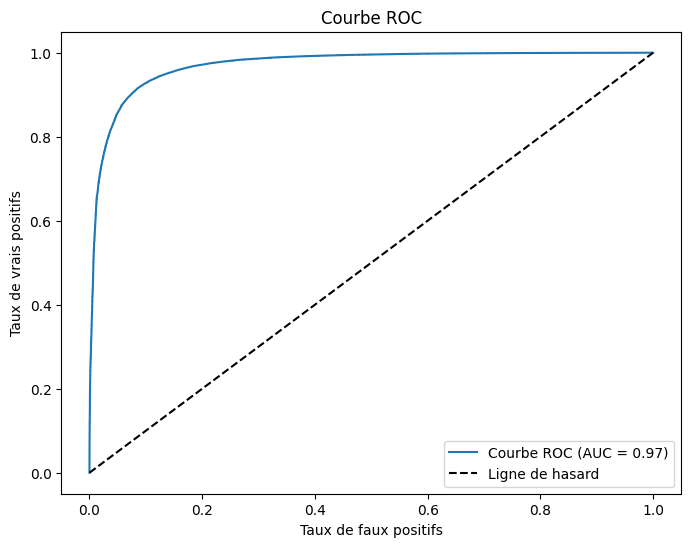

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Prédire les probabilités  
y_proba = model.predict_proba(X_test)[:, 1]

# Calculer le taux de faux positifs (FPR) et le taux de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculer l'AUC
auc = roc_auc_score(y_test, y_proba)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Ligne de hasard')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()
